In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn utility
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics   
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedStratifiedKFold

#XGB
from xgboost import XGBClassifier
import xgboost as xgb

# CatBoost
from catboost import CatBoostClassifier
import catboost as catboost

# sklearn ensembles 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train["Age"].fillna(train["Age"].mean(), inplace=True)
test["Age"].fillna(test["Age"].mean(), inplace=True)
test["Fare"].fillna(test["Fare"].mean(), inplace=True)

In [4]:
def prepare_titanic_data(train, test, test_size=0.1):
        
    features_remove=['Name','PassengerId','Survived', 'Cabin', 'Ticket']
    y = train['Survived']
    X = train.drop(features_remove, axis=1)
    
    test_id = test['PassengerId']
    test = test.drop(['Name','PassengerId', 'Cabin', 'Ticket'], axis=1)
    
    assert len(X.columns) == len(test.columns)
    
    train_len = len(X)

    merged = pd.concat([X, test])
    
    categorical_features = []
    for c in merged.columns:
        col_type = merged[c].dtype
        if col_type == "object" or col_type.name == "category":
            # an option in case the data(pandas dataframe) isn't passed with the categorical column type
            # X[c] = X[c].astype('category')
            categorical_features.append(c)
            
            
    merged = pd.get_dummies(data=merged, columns=categorical_features)

    train_x = merged.iloc[:train_len,:]
    test = merged.iloc[train_len:, :]
    
    tx, vx, ty, vy = train_test_split(train_x, y, test_size = test_size)
    
    return tx, ty, vx, vy, test_id, test

In [5]:
def evaluate_model_performnce(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualizing model performance
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 

    tn, fp, fn, tp = cm.ravel()
    #print(tn, fp, fn, tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = ((tp+tn)/(tp+tn+fp+fn))*100
    print("Precision : ",precision)
    print("Recall : ",recall)
    print("F1 Score : ",f1)
    print("Validation Accuracy : ",accuracy)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy Score : ", accuracy)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    print("AUC Value : ", auc)
    
    return accuracy, auc, f1

In [6]:
def make_submission_file(filename, probab, test_id, IdCol, targetCol, threshold=None):
    submit = pd.DataFrame()
    submit[IdCol] = test_id
    submit[targetCol] = probab
    if threshold!=None:
        pred = [1 if x>=threshold else 0 for x in probab]
        submit[targetCol] = pred
    submit.to_csv(filename, index=False)
    return submit

In [7]:
train_x, train_y, val_x, val_y, test_id, test_x = prepare_titanic_data(train, test, test_size=0.2)
IdCol = 'PassengerId'
targetCol = 'Survived'
dataset='titanic'

In [8]:
val_x

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
579,3,32.000000,0,0,7.9250,0,1,0,0,1
742,1,21.000000,2,2,262.3750,1,0,1,0,0
39,3,14.000000,1,0,11.2417,1,0,1,0,0
497,3,29.699118,0,0,15.1000,0,1,0,0,1
21,2,34.000000,0,0,13.0000,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
571,1,53.000000,2,0,51.4792,1,0,0,0,1
405,2,34.000000,1,0,21.0000,0,1,0,0,1
622,3,20.000000,1,1,15.7417,0,1,1,0,0
761,3,41.000000,0,0,7.1250,0,1,0,0,1


In [9]:
xgb_clf = XGBClassifier()
xgb_clf.fit(train_x, train_y, eval_metric=["auc", "logloss"], verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Precision :  0.7051282051282052
Recall :  0.8088235294117647
F1 Score :  0.7534246575342467
Validation Accuracy :  79.88826815642457
Accuracy Score :  0.7988826815642458
AUC Value :  0.8008081611022787


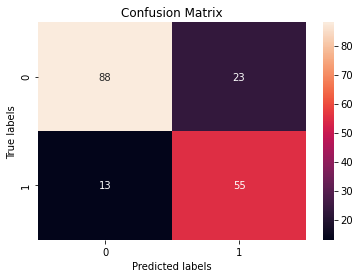

In [10]:
threshold = 0.4
xgb_val_prob = xgb_clf.predict_proba(val_x)
xgb_val_prob = pd.DataFrame(xgb_val_prob)[1]
xgb_val_pred = [1 if x >= threshold else 0 for x in xgb_val_prob]
xgb_acc, xgb_auc, xgb_f1 = evaluate_model_performnce(val_y, xgb_val_pred) 

In [11]:
xgb_prob = xgb_clf.predict_proba(test_x)
xgb_prob = pd.DataFrame(xgb_prob)[1]

In [12]:
xgb_prob

0      0.036937
1      0.048205
2      0.267913
3      0.489949
4      0.346428
         ...   
413    0.045498
414    0.999493
415    0.003616
416    0.045498
417    0.051136
Name: 1, Length: 418, dtype: float32

In [13]:
xgb_sub = make_submission_file(dataset+"_xgb_default.csv", xgb_prob, test_id, IdCol, targetCol, threshold=0.5)
xgb_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [14]:
cat_clf = CatBoostClassifier(verbose=0)
cat_clf.fit(train_x, train_y)

Precision :  0.7142857142857143
Recall :  0.8088235294117647
F1 Score :  0.7586206896551725
Validation Accuracy :  80.44692737430168
Accuracy Score :  0.8044692737430168
AUC Value :  0.8053126656067833


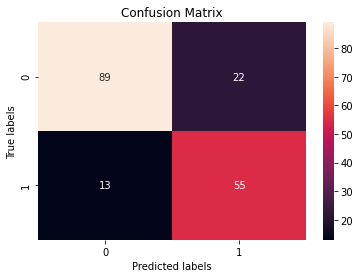

In [15]:
threshold = 0.4
cat_val_prob = cat_clf.predict_proba(val_x)
cat_val_prob = pd.DataFrame(cat_val_prob)[1]
cat_val_pred = [1 if x >= threshold else 0 for x in cat_val_prob]
cat_acc, cat_auc, cat_f1 = evaluate_model_performnce(val_y, cat_val_pred) 

In [16]:
cat_prob = cat_clf.predict_proba(test_x)
cat_prob = pd.DataFrame(cat_prob)[1]

In [17]:
cat_prob

0      0.055723
1      0.261894
2      0.156391
3      0.155828
4      0.397453
         ...   
413    0.118564
414    0.985617
415    0.048377
416    0.118564
417    0.271252
Name: 1, Length: 418, dtype: float64

In [18]:
cat_sub = make_submission_file(dataset+"_cat_default.csv", cat_prob, test_id, IdCol, targetCol, threshold=0.5)
cat_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [19]:
ens_val_prob = 0.55*cat_val_prob + 0.45*xgb_val_prob

Precision :  0.7142857142857143
Recall :  0.8088235294117647
F1 Score :  0.7586206896551725
Validation Accuracy :  80.44692737430168
Accuracy Score :  0.8044692737430168
AUC Value :  0.8053126656067833


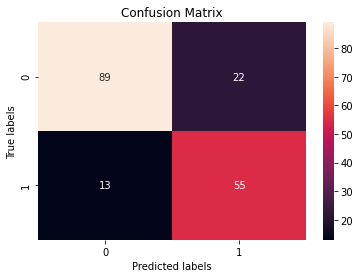

In [20]:
threshold = 0.4
ens_val_pred = [1 if x >= threshold else 0 for x in ens_val_prob]
ens_acc, ens_auc, ens_f1 = evaluate_model_performnce(val_y, ens_val_pred) 

In [21]:
ens_prob = 0.55*cat_prob + 0.45*xgb_prob

In [22]:
ens_sub = make_submission_file(dataset+"_weighted_ens.csv", ens_prob, test_id, IdCol, targetCol, threshold=0.5)
ens_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [23]:
trained_clfs = [xgb_clf, cat_clf]

def ensembling_engine(trained_clfs, train_x, train_y, test_x, ensembler):
    train_matrix = np.empty((train_x.shape[0], len(trained_clfs)))
    for (n, clf) in enumerate(trained_clfs):
        train_matrix[:,n] = pd.DataFrame(clf.predict_proba(train_x))[1]      #pd.DataFrame(cat_prob)[1]
        
    ensembler.fit(train_matrix, train_y)
    
    test_matrix = np.empty((test_x.shape[0], len(trained_clfs)))
    for (n, clf) in enumerate(trained_clfs):
        test_matrix[:,n] = pd.DataFrame(clf.predict_proba(test_x))[1]   
        
    ens_prob = ensembler.predict_proba(test_matrix)
    return ens_prob

In [24]:
ensembler = LogisticRegression()

Precision :  0.7142857142857143
Recall :  0.8088235294117647
F1 Score :  0.7586206896551725
Validation Accuracy :  80.44692737430168
Accuracy Score :  0.8044692737430168
AUC Value :  0.8053126656067833


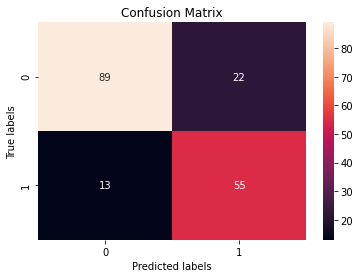

In [25]:
lr_ens_val_prob = ensembling_engine(trained_clfs, train_x, train_y, val_x, ensembler)
lr_ens_val_prob = pd.DataFrame(lr_ens_val_prob)[1]
threshold = 0.4
lr_ens_val_pred = [1 if x >= threshold else 0 for x in lr_ens_val_prob]
le_ens_acc, lr_ens_auc, lr_ens_f1 = evaluate_model_performnce(val_y, lr_ens_val_pred) 

In [26]:
lr_ens_prob = ensembling_engine(trained_clfs, train_x, train_y, test_x, ensembler)
lr_ens_prob = pd.DataFrame(lr_ens_prob)[1]
#lr_ens_prob
lr_ens_sub = make_submission_file(dataset+"lr_ens.csv", lr_ens_prob, test_id, IdCol, targetCol, threshold=0.5)
lr_ens_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [27]:
from sklearn.ensemble import StackingClassifier

In [28]:
st_xgb = XGBClassifier()
st_cat = CatBoostClassifier(verbose=0)

st_clf = StackingClassifier(estimators=[('xgb', st_xgb), ('cat', st_cat)], 
                            final_estimator=GradientBoostingClassifier())
st_clf.fit(train_x, train_y)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None,
                                              max_depth=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100,

Precision :  0.6712328767123288
Recall :  0.7205882352941176
F1 Score :  0.6950354609929077
Validation Accuracy :  75.97765363128491
Accuracy Score :  0.7597765363128491
AUC Value :  0.7521860095389508


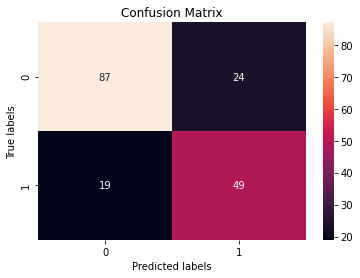

In [29]:
threshold = 0.4
st_val_prob = st_clf.predict_proba(val_x)
st_val_prob = pd.DataFrame(st_val_prob)[1]
st_val_pred = [1 if x >= threshold else 0 for x in st_val_prob]
st_acc, st_auc, st_f1 = evaluate_model_performnce(val_y, st_val_pred) 

In [30]:
st_prob = st_clf.predict_proba(test_x)
st_prob = pd.DataFrame(st_prob)[1]

In [31]:
st_sub = make_submission_file(dataset+"_stacking_ens.csv", st_prob, test_id, IdCol, targetCol, threshold=0.5)
st_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [32]:
from sklearn.ensemble import VotingClassifier

In [33]:
v_xgb = XGBClassifier()
v_cat = CatBoostClassifier(verbose=0)

v_clf = VotingClassifier(estimators=[('xgb', v_xgb), ('cat', v_cat)], voting='soft')
v_clf.fit(train_x, train_y)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
 

Precision :  0.7051282051282052
Recall :  0.8088235294117647
F1 Score :  0.7534246575342467
Validation Accuracy :  79.88826815642457
Accuracy Score :  0.7988826815642458
AUC Value :  0.8008081611022787


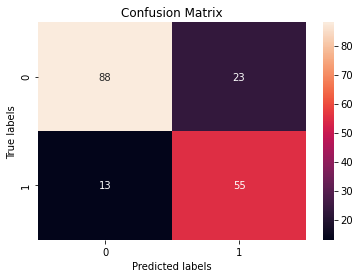

In [34]:
threshold = 0.4
v_val_prob = v_clf.predict_proba(val_x)
v_val_prob = pd.DataFrame(v_val_prob)[1]
v_val_pred = [1 if x >= threshold else 0 for x in v_val_prob]
v_acc, v_auc, v_f1 = evaluate_model_performnce(val_y, v_val_pred) 

In [35]:
v_prob = v_clf.predict_proba(test_x)
v_prob = pd.DataFrame(v_prob)[1]

In [36]:
v_sub = make_submission_file(dataset+"_voting_ens.csv", v_prob, test_id, IdCol, targetCol, threshold=0.5)
v_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [37]:
model_name = ['XGBM', 'CatBoost', 'Ensemble']
acc = [xgb_acc, cat_acc, v_acc]
auc = [xgb_auc, cat_auc, v_auc]
f1 = [xgb_f1, cat_f1, v_f1]

summary = pd.DataFrame({"model":model_name,
                       "accuracy":acc,
                       "auc":auc,
                       "f1_score":f1})
summary

,model,accuracy,auc,f1_score
0,XGBM,0.798883,0.800808,0.753425
1,CatBoost,0.804469,0.805313,0.758621
2,Ensemble,0.798883,0.800808,0.753425


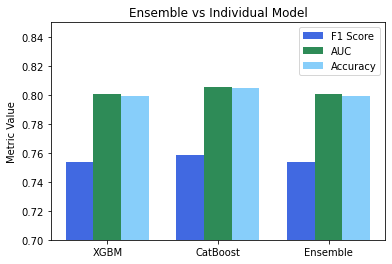

In [38]:
N = 3
#menMeans = (20, 35, 30, 35, 27)
#menStd =   (2, 3, 4, 1, 2)

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, summary['f1_score'], width, color='royalblue')

#womenMeans = (25, 32, 34, 20, 25)
#womenStd =   (3, 5, 2, 3, 3)
rects2 = ax.bar(ind+width, summary['auc'], width, color='seagreen')
rects3 = ax.bar(ind+width+width, summary['accuracy'], width, color='lightskyblue')


# add some
ax.set_ylabel('Metric Value')
ax.set_ylim([0.7,0.85])
ax.set_title('Ensemble vs Individual Model')
ax.set_xticks(ind + 2*width / 2)
ax.set_xticklabels( (summary['model']) )

ax.legend( (rects1[0], rects2[0], rects3[0]), ('F1 Score', 'AUC', 'Accuracy') )
fig.savefig("comp.png")

plt.show()